# Accelerating Text Classification with Snorkel

It is now well understood that state of the art models and hardware have been commoditized but training data is still a challenge for many supervised learning algorithms. There is a massive drive towards generating high quality training data for the AI applications to succeed.



Open-source Snorkel framework is tackling this through data programming. I.e. to use diverse organizational knowledge resources—like internal models, ontologies, legacy rules, knowledge graphs and more—in order to generate training data for machine learning models at web scale.[1].

In our objective to classify issues in an issues management system into classes such as - Bugs, New Feature or Maintenance we planned on using a transformer model and tune it further to help us accelarate on the goal.  We have a dataset of issues and we need labels for those issues to train a pre-trained BERT variant for our specific domain.

We decided to evaluate Snorkel on our issues classification/labelling tasks before scaling it further for our needs.

In this notebook I am going to give an overview of the features of Snorkel library that lets us build and manage training datasets programatically. 

We are also going to look at other important aspects such as focusing on problem slices of your dataset. 
It allows us to evaluate them and apply fixes and integrate it to train again, enabling a true iterative model development through remediation of your dataset labels.

In [3]:
import logging
import os
import numpy as np
import random
import torch

The intuition behind this pattern is to use the problem domain expertise to enable data labelling programatically through heuristics. Allowing for rapid deployment, testing and iteration of ML models, with a focus on solving the problem at hand.

Some history behind the idea of weak supervision and data labelling of Snorkel can be found in [1]

### Briefly the snorkel library has :

* Labeling:
    Generate labels for the data, and reconcile those labels generating a single one at the end

* Analysis: 
   Evaluating label metrics.

* Augmentation:
   Generate new data samples

* Slicing:
   Monitor subsets of data

* Classification:
   Tools to train multitask models

In this notebook we are going to look at use of Labeling, Analysis and Slicing modules.

In [4]:
import pandas as pd
import snorkel
import numpy as np
from simpletransformers.classification import ClassificationModel

In [240]:
df_frames = pd.read_csv('training.csv')

In [ ]:
df_frames = df_frames.astype({"issue_id": int, "text": str})
df_frames.dtypes

In [241]:
df_train.head()

,Unnamed: 0,issue_id,text,zero_shot_label,zeroshotlabel,snorkel,xlnet_label
0,0,487922,Bug Internal costs allocation is not calculati...,Defect,1,1,1
1,1,487693,Story Prepare videos | Ad Russia,New Feature,2,-1,2
2,2,487981,Bug Inconsistent approach to calculating order...,Defect,1,1,1
3,3,487992,"Bug Digital Campaign Name, Start and End date ...",Defect,1,3,1
4,4,488110,Story BM: Create SF_ORD_CRE_REQ messages,Continue Operation,0,2,2


In [233]:
df_frames.tail()

,issue_id,text,zero_shot_label,zeroshotlabel,snorkel,xlnet_label
1995,205597,Bug [QA1-Slack Enterprise]Creating multiple cc...,Defect,1,1,1
1996,205596,Bug [20.7][GSuiteOtherApps][Google Contacts] :...,Defect,1,1,1
1997,205166,Bug [XXXXX] Content Rule Templates Names didn'...,Defect,1,1,1
1998,205165,Bug [XXXXX] - Slack Policy Rule changed from D...,Defect,1,1,1
1999,205164,Bug [XXXXX] - Content Rule Name Changed/Modifi...,Defect,1,0,1


A Baseline model - build using zero-shot-classification

In [17]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", device=0)
candidate_labels=["Defect", "Software Research", "Software Upgrade", "Testing", "Software Development", "Software Maintenance", "Software Deployment", "Software Enhancement", "Software Integration", "New Feature", "Innovation", "R&D", "Continue Operation", "Other", "Technical Debt"]

In [22]:
filter_keys = ['labels']
def predict_0_shot_label(summary):
    result = classifier(summary, candidate_labels)
    temp = list(map(result.get, filter_keys))
    zero_shot_label = temp[0][0]
    return zero_shot_label

In [23]:
def translate_label(label_text):
    if label_text in ['New Feature', 'Innovation', 'R&D', 'Software Research', 'Software Development', 'Software Enhancement']:
        return 2
    elif label_text in ['Testing', 'Continue Operation', 'Technical Debt', 'Software Maintenance', 'Software Upgrade', 'Software Deployment', 'Software Integration']:
        return 0
    elif label_text in ['Defect']:
        return 1   
    else:
        return 3

In [24]:
df_frames['zero_shot_label'] = df_frames['text'].apply(predict_0_shot_label)

In [25]:
df_frames['zeroshotlabel'] = df_frames['zero_shot_label'].apply(translate_label)

In [26]:
df_frames.head()

,issue_id,text,zero_shot_label,zeroshotlabel
0,487922,Bug Internal costs allocation is not calculati...,Defect,1
1,487693,Story Prepare videos | Ad Russia,New Feature,2
2,487981,Bug Inconsistent approach to calculating order...,Defect,1
3,487992,"Bug Digital Campaign Name, Start and End date ...",Defect,1
4,488110,Story BM: Create SF_ORD_CRE_REQ messages,Continue Operation,0


[1] Snorkel framework allows users to generically specify multiple sources of programmatic weak supervision—such as rules and pattern matchers over text—that can vary in accuracy, coverage, and that may be arbitrarily correlated. 

The Snorkel pipeline follows three main stages: first, users write labeling functions, which are simply black-box functions that take in unlabeled data points and output a label or abstain; next, a generative model is used to estimate the accuracies of the different labeling functions, and then to re-weight and combine their labels to produce a set of probabilistic training labels, effectively solving a novel data cleaning and integration problem; and finally, these labels are use to train an arbitrary end discriminative model, which is used as the final classifier in production.

### Weakly Supervised learning using Snorkel's Labeling Function

In [27]:
# Define the label mappings for convenience
ABSTAIN = -1
MAINTENANCE = 0
BUG = 1
RD = 2
OTHER = 3

In [28]:
from snorkel.labeling import labeling_function

In [29]:
@labeling_function()
def maintenance(x):
    return MAINTENANCE if "switch" in x['text'].lower() or "improvement" in x.text.lower() or 'upgrade' in x['text'].lower() or 'update' in x['text'].lower() or 'alert' in x['text'].lower() or 'remove' in x['text'].lower() or 'clean' in x['text'].lower() or 'deploy' in x['text'].lower() or 'offboard' in x['text'].lower() or 'access' in x['text'].lower() or 'support' in x['text'].lower() else ABSTAIN

@labeling_function()
def bug(x):
    return BUG if "fail" in x['text'].lower() or "bug" in x.text.lower() or "error" in x.text.lower() or "resolve" in x.text.lower() or "issue" in x.text.lower() else ABSTAIN

@labeling_function()
def new_feature(x):
    # Return a label, otherwise ABSTAIN
    return RD if "feature" in x['text'].lower() or "experiment" in x['text'].lower() or 'new' in x['text'].lower() or 'spike' in x['text'].lower() or 'add' in x['text'].lower() or 'build' in x['text'].lower() or 'create' in x['text'].lower() or 'enable' in x['text'].lower() or 'design' in x['text'].lower() or 'implement' in x['text'].lower() or 'report' in x['text'].lower() else ABSTAIN

@labeling_function()
def tech_debt(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return MAINTENANCE if "verif" in x['text'].lower() or "qa" in x['text'].lower() or "test" in x['text'].lower() or "release" in x['text'].lower() or "migrate" in x['text'].lower() or "Technical Debt" in x['text'] or 'Tech Debt' in x['text'] or 'request' in x['text'].lower() or 'clean' in x['text'].lower() or 'validat' in x['text'].lower() or 'script' in x['text'].lower() or 'monitor' in x['text'].lower() or 'tuni' in x['text'].lower() else ABSTAIN

@labeling_function()
def enhancement(x):
    # Return a label , otherwise ABSTAIN
    return RD if "enhancement" in x['text'].lower() else ABSTAIN

@labeling_function()
def other(x):
    return OTHER if "help" in x['text'].lower() or "campaign" in x['text'].lower() or "setup" in x['text'].lower() or "query" in x['text'].lower() or "investigate" in x['text'].lower() or "terminate" in x['text'].lower() or "document" in x['text'].lower() or "review" in x['text'].lower() or "retro" in x['text'].lower() or "consultancy" in x['text'].lower() or "external" in x['text'].lower() or "communica" in x['text'].lower() else ABSTAIN

@labeling_function()
def predict_0_shot_label(x):
    result = classifier(x.text, candidate_labels)
    temp = list(map(result.get, filter_keys))
    zero_shot_label = temp[0][0]
    return zeroshotlabel(zero_shot_label)

def zeroshotlabel(label_text):
    if label_text in ['New Feature', 'Innovation', 'R&D', 'Software Research', 'Software Development', 'Software Enhancement']:
        return RD
    elif label_text in ['Testing', 'Continue Operation', 'Technical Debt', 'Software Maintenance', 'Software Upgrade', 'Software Deployment', 'Software Integration']:
        return MAINTENANCE
    elif label_text in ['Defect']:
        return BUG  
    else:
        return OTHER

In [30]:
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

In [31]:
# Define the set of labeling functions (LFs)
lfs = [maintenance, bug, new_feature, tech_debt, enhancement, other, predict_0_shot_label]

In [32]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_frames)

100%|██████████| 6856/6856 [11:49<00:00,  9.66it/s]


In [33]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
df_frames["snorkel"] = label_model.predict(L=L_train, tie_break_policy="abstain")

In [34]:
non_labelled = df_frames[df_frames.snorkel == -1]

In [ ]:
non_labelled.count()

Evaluating snorkel labels

In [36]:
L_train_full = applier.apply(df_frames)
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train_full, n_epochs=500, log_freq=50, seed=123)
metrics = label_model.score(L=L_train_full, Y=df_frames.zeroshotlabel, 
                            tie_break_policy="abstain",
                            metrics=["accuracy"
                            , "coverage", "f1_macro", "f1_micro"])

label_model_acc = metrics["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")
print("All Metrics: ", metrics)

100%|██████████| 6856/6856 [11:48<00:00,  9.67it/s]


Label Model Accuracy:     95.6%
All Metrics:  {'accuracy': 0.9556592765460911, 'coverage': 1.0, 'f1_macro': 0.9109312577717841, 'f1_micro': 0.9556592765460911}


In [37]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
maintenance,0,[0],0.177071,0.177071,0.157526
bug,1,[1],0.456680,0.456680,0.215286
new_feature,2,[2],0.203617,0.203617,0.132585
tech_debt,3,[0],0.161027,0.161027,0.126167
enhancement,4,[2],0.004813,0.004813,0.000729
other,5,[3],0.078180,0.078180,0.075117
predict_0_shot_label,6,"[0, 1, 2, 3]",1.000000,0.778005,0.409422


Distribution of labels

<AxesSubplot:>

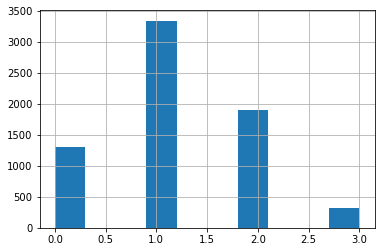

In [213]:
df_frames["snorkel"].hist()

In [39]:
df_frames.head()

,issue_id,text,zero_shot_label,zeroshotlabel,snorkel
0,487922,Bug Internal costs allocation is not calculati...,Defect,1,1
1,487693,Story Prepare videos | Ad Russia,New Feature,2,2
2,487981,Bug Inconsistent approach to calculating order...,Defect,1,1
3,487992,"Bug Digital Campaign Name, Start and End date ...",Defect,1,1
4,488110,Story BM: Create SF_ORD_CRE_REQ messages,Continue Operation,0,0


Snorkel has several options for hyperparameter tuning to improve the quality of labeling even further.

In [40]:
# Grid Search
from itertools import product
lrs = [1e-1, 1e-2, 1e-3]
l2s = [0, 1e-1, 1e-2]
n_epochs = [100, 200, 500]
optimizer = ["sgd", "adam"]
thresh = [0.6, 0.7] #[0.5, 0.6]
lma_best = 0
params_best = []
for params in product(lrs, l2s, n_epochs, optimizer, thresh):
    # do the initial pass to access the accuracies
    label_model.fit(L_train_full, n_epochs=params[2], log_freq=50, 
                    seed=123, optimizer=params[3], lr=params[0], 
                    l2=params[1])
    
    # accuracies
    weights = label_model.get_weights()
    # print(weights)
    
    # LFs above our threshold 
    vals = weights > params[4]
    
    # the LM requires at least 3 LFs to train
    if sum(vals) >= 3:
        L_filtered = L_train_full[:, vals]
        label_model.fit(L_filtered, n_epochs=params[2], 
                        log_freq=50, seed=123, 
                        optimizer=params[3], lr=params[0], 
                        l2=params[1])
        label_model_acc = label_model.score(L=L_filtered, 
                          Y=df_frames.zeroshotlabel, 
                          tie_break_policy="abstain")["accuracy"]
        # print(label_model_acc)
        if label_model_acc > lma_best:
            lma_best = label_model_acc
            params_best = params
        
print("best = ", lma_best, " params ", params_best)

best =  0.9763710618436406  params  (0.1, 0, 100, 'sgd', 0.6)


Previously trained Xlnet Model

In [42]:
train_args ={"reprocess_input_data": True, "overwrite_output_dir": False}
model_folder = '../production/pipeline'

model = ClassificationModel("xlnet", model_folder, use_cuda=False, num_labels=4, args=train_args)


In [77]:
def predict_label(summary):
    predictions, raw_outputs = model.predict([summary])
    return predictions[0]

In [ ]:
df_frames['xlnet_label'] = df_frames['text'].apply(predict_label)

In [80]:
df_frames.head()

,issue_id,text,zero_shot_label,zeroshotlabel,snorkel,snorkel_new,xlnet_label
0,487922,Bug Internal costs allocation is not calculati...,Defect,1,1,1,1
1,487693,Story Prepare videos | Ad Russia,New Feature,2,2,2,2
2,487981,Bug Inconsistent approach to calculating order...,Defect,1,1,1,1
3,487992,"Bug Digital Campaign Name, Start and End date ...",Defect,1,1,1,1
4,488110,Story BM: Create SF_ORD_CRE_REQ messages,Continue Operation,0,0,0,2


Evaluating the model 

In [47]:
from sklearn.metrics import precision_recall_fscore_support
import json

In [211]:
y_true = df_frames['xlnet_label'].tolist()
y_pred = df_frames['snorkel'].tolist()

In [212]:
# Metrics
metrics = {"overall": {}, "class": {}}

# Evaluate
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_true))
print (json.dumps(metrics["overall"], indent=4))


{
    "precision": 0.7096614492993274,
    "recall": 0.6998249708284714,
    "f1": 0.6956091187204573,
    "num_samples": 6856.0
}


In [214]:
label_classes = df_frames.xlnet_label.unique()

In [216]:
label_classes = sorted(label_classes)

In [217]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
for i, _class in enumerate(label_classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [218]:
class_metrics = precision_recall_fscore_support(y_true, y_pred, average=None)

In [219]:
class_metrics

(array([0.62971517, 0.8340311 , 0.61445148, 0.08201893]),
 array([0.4061569 , 0.91412652, 0.68489124, 0.28888889]),
 array([0.49381225, 0.87224394, 0.64776202, 0.12776413]),
 array([2014, 3051, 1701,   90]))

In [252]:
# Metrics for a specific class
tag = 3
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.08201892744479496,
  "recall": 0.28888888888888886,
  "f1": 0.12776412776412777,
  "num_samples": 90.0
}


In [221]:
lebelled_df = df_frames[df_frames.snorkel != -1]

In [222]:
# Num samples by class
num_samples = lebelled_df.groupby(['snorkel']).size()

In [223]:
num_samples

snorkel
0    1299
1    3344
2    1896
3     317
dtype: int64

In [224]:
f1s = [metrics["class"][_class]["f1"]*100. for _class in label_classes]

In [225]:
f1s

[49.38122547539994, 87.2243940578577, 64.7762023908813, 12.776412776412776]

In [228]:
# samples vs. performance
f1s = [metrics["class"][_class]["f1"]*100. for _class in label_classes]
# sorted_lists = zip(*[num_samples, f1s])
sorted_lists = sorted(zip(*[num_samples, f1s]))
num_samples, f1s = list(zip(*sorted_lists))

In [231]:
labelClasses = ['Other', 'Maintenance', 'R&D', 'Bug']

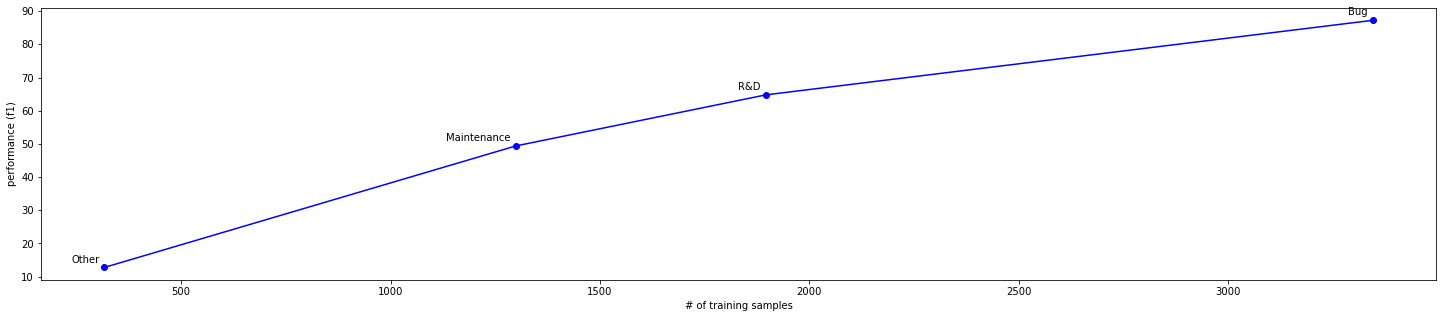

In [235]:
# Plot
import matplotlib.pyplot as plt
n = 4
fig, ax = plt.subplots()
ax.set_xlabel("# of training samples")
ax.set_ylabel("performance (f1)")
fig.set_size_inches(25, 5)
ax.plot(num_samples, f1s, "bo-")
for x, y, label in zip(num_samples[-n:], f1s[-n:], labelClasses[-n:]):
    ax.annotate(label, xy=(x,y), xytext=(-5, 5), ha="right", textcoords="offset points")

Evaluate performance on key slices of data 

Overall metrics are not good enough. Ability to understand the poor performing slices and human intervention into the process is essential for improving production ML solutions. In this section we look at how Snorkel's slicing module enables some of these aspects.

In [236]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [253]:
@slicing_function()
def other_slice(x):
    return OTHER if "bug" not in x['text'].lower() and ("help" in x['text'].lower() or "campaign" in x['text'].lower() or "setup" in x['text'].lower() or "query" in x['text'].lower() or "investigate" in x['text'].lower() or "terminate" in x['text'].lower() or "document" in x['text'].lower() or "review" in x['text'].lower() or "retro" in x['text'].lower() or "consultancy" in x['text'].lower() or "external" in x['text'].lower() or "communica" in x['text'].lower()) else ABSTAIN

@slicing_function()
def new_feature(x):
    # Return a label, otherwise ABSTAIN
    return RD if "feature" in x['text'].lower() or "experiment" in x['text'].lower() or 'new' in x['text'].lower() or 'spike' in x['text'].lower() or 'add' in x['text'].lower() or 'build' in x['text'].lower() or 'create' in x['text'].lower() or 'enable' in x['text'].lower() or 'design' in x['text'].lower() or 'implement' in x['text'].lower() or 'report' in x['text'].lower() else ABSTAIN


In [254]:
rd_df = slice_dataframe(df_frames, new_feature)

100%|██████████| 6856/6856 [00:00<00:00, 28806.33it/s]


In [255]:
rd_df.head()

,issue_id,text,zero_shot_label,zeroshotlabel,snorkel,snorkel_new,xlnet_label
0,487922,Bug Internal costs allocation is not calculati...,Defect,1,1,1,1
1,487693,Story Prepare videos | Ad Russia,New Feature,2,2,2,2
2,487981,Bug Inconsistent approach to calculating order...,Defect,1,1,1,1
3,487992,"Bug Digital Campaign Name, Start and End date ...",Defect,1,1,1,1
4,488110,Story BM: Create SF_ORD_CRE_REQ messages,Continue Operation,0,0,0,2


In [256]:
# Slices
slicing_functions = [new_feature]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(lebelled_df)
slices

100%|██████████| 6856/6856 [00:00<00:00, 29112.96it/s]


rec.array([(-1,), (-1,), (-1,), ..., (-1,), (-1,), (-1,)],
          dtype=[('new_feature', '<i8')])

In [257]:
y_true = lebelled_df['xlnet_label'].tolist()
y_pred = lebelled_df['snorkel'].tolist()
y_test = lebelled_df['xlnet_label'].values

In [258]:
from snorkel.utils import preds_to_probs

preds_test = lebelled_df['snorkel'].values
probs_test = preds_to_probs(preds_test, 4)

Retrieve our slice metrics

In [259]:
from snorkel.analysis import Scorer

scorer = Scorer(metrics=["f1_macro", "f1_micro", "accuracy"])

In [260]:
scorer.score_slices(
    S=slices, golds=y_test, preds=preds_test, probs=probs_test, as_dataframe=True
)

,f1_macro,f1_micro,accuracy
overall,0.535396,0.699825,0.699825
new_feature,0.535396,0.699825,0.699825


In [83]:
eval_data.read_csv('eval.csv')

In [75]:
eval_data = pd.DataFrame(eval_data)
eval_data.columns = ['text', 'labels']

In [ ]:
eval_data['xlnet_label'] = eval_data['text'].apply(predict_label)

In [79]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = eval_data['labels'].tolist()
y_pred = eval_data['xlnet_label'].tolist()  #list(np.concatenate(predictions).flat)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47        68
           1       0.63      0.95      0.76        61
           2       0.49      0.48      0.48        44
           3       1.00      0.04      0.07        27

    accuracy                           0.56       200
   macro avg       0.65      0.48      0.45       200
weighted avg       0.60      0.56      0.51       200



In [85]:
model_name = 'roberta' #'electra'##"xlnet"
model_type = 'roberta-base'#'google/electra-small-discriminator'#"xlnet-base-cased"

train_args = {
    'output_dir': f'{model_type}-{model_name}-outputs',

    'max_seq_length': 256,
    'num_train_epochs': 5,
    'train_batch_size': 16,
    'eval_batch_size': 32,
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'save_steps': 50000,

    'wandb_project': 'ag-news-transformers-comparison',
    'wandb_kwargs': {'name': f'{model_type}-{model_name}'},
    'evaluate_during_training': True,
    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
}

In [84]:
# Get the unique labels
categories = df_frames.snorkel.unique()
categories

array([1, 2, 0, 3])

In [86]:
# Create a ClassificationModel
model = ClassificationModel(
    model_name,
    model_type,
    num_labels=len(categories),args=train_args
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [87]:
X = df_frames.loc[:,['text', 'snorkel']]

In [92]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(X, test_size = 0.2, random_state = 2021)
print(df_train.shape, df_val.shape)

(5484, 2) (1372, 2)


In [98]:
# Train the model
model.train_model(df_train, eval_df=df_val)

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:616: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/5484 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

_runtime,5
_timestamp,1633368304
_step,2


_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█


wandb: You can sync this run to the cloud by running:
wandb: wandb sync /home/jupyter/snorkel/wandb/offline-run-20211004_172457-211n0o4v


wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Running Epoch 0 of 5:   0%|          | 0/343 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/343 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/343 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/343 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/343 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

(1715,
 {'global_step': [343, 686, 1000, 1029, 1372, 1715],
  'mcc': [0.7239022544773321,
   0.7290908305207312,
   0.7236825137911609,
   0.7540138803710128,
   0.7485790319361932,
   0.7448347011653819],
  'train_loss': [0.42033863067626953,
   0.4354438781738281,
   0.16752392053604126,
   0.021520614624023438,
   0.5627015233039856,
   0.003447334049269557],
  'eval_loss': [0.7241885786832765,
   0.7302038517109183,
   0.8098233924355618,
   0.7423101531904798,
   0.9303313750167226,
   0.9480593738167785]})

In [95]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [96]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_val)

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1372 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/43 [00:00<?, ?it/s]

_runtime,5
_timestamp,1633368206
_step,2


_runtime,▁▁▁
_timestamp,▁▁▁
_step,▁▅█


wandb: You can sync this run to the cloud by running:
wandb: wandb sync /home/jupyter/snorkel/wandb/offline-run-20211004_172318-2o9fyqfk


wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


In [97]:
result

{'mcc': 0.7386294269537602, 'eval_loss': 0.6727352267087892}

In [100]:
def predict_roberta_label(summary):
    predictions, raw_outputs = model.predict([summary])
    return predictions[0]

In [ ]:
eval_data['roberta_label'] = eval_data['text'].apply(predict_roberta_label)

In [102]:
eval_data.head()

,text,labels,xlnet_label,roberta_label
0,Taks R2 Reports - Revenues by Strategic Product,2,2,0
1,Story R2 Reports - Weekly Digital Revenue Report,2,2,0
2,Taks Reporting Request_Ciroc_7819_5.7.21_Shopp...,2,2,0
3,Taks Copilot: Create an original piece of cont...,2,2,0
4,Story COVID Hair Portfolio,2,2,2


In [106]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = eval_data['labels'].tolist()
y_pred = eval_data['xlnet_label'].tolist()  #list(np.concatenate(predictions).flat)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47        68
           1       0.63      0.95      0.76        61
           2       0.49      0.48      0.48        44
           3       1.00      0.04      0.07        27

    accuracy                           0.56       200
   macro avg       0.65      0.48      0.45       200
weighted avg       0.60      0.56      0.51       200



### References


[1] Google AI Blog: Harnessing Organizational Knowledge for Machine Learning

[2] https://www.snorkel.org/use-cases/ 

[3] https://github.com/ThilinaRajapakse/simpletransformers

### Example Use Cases of Snorkel Pattern in production

* Apple's Overton Project using ideas from Snorkel

* Google AI Blog: Harnessing Organizational Knowledge for Machine Learning

* MRI Image Sequence Classification Work: Weakly supervised classification of aortic valve malformations using unlabeled cardiac MRI sequences